In [5]:
import pandas as pd

In [6]:
import io

In [7]:
import matplotlib.pyplot as plt

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [9]:
import tensorflow as tf

## Importing Training and Testing Databases

In [15]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv


In [11]:
train = pd.read_csv(io.BytesIO(uploaded['Train.csv']))

In [14]:
test = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

#### Training Dataset

In [17]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


Segmentation is the dependent variable.

In [18]:
train.isna().sum() #null values in all columns

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

##### Handling Nan Values

##### Ever Married

In [19]:
train.groupby(['Ever_Married']).count() #shows 4643 Yes's and 3285 No's

,ID,Gender,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Ever_Married,,,,,,,,,,
No,3285,3285,3285,3254,3235,2960,3285,3101,3255,3285
Yes,4643,4643,4643,4600,4573,4162,4643,4504,4598,4643


In [20]:
#Family size of 1 is more likely for people who never married
train.loc[(train.Family_Size == 1) & (train.Ever_Married.isna()), "Ever_Married"] = 'No' 

In [21]:
#Age of 18 or less is more like to have never married
train.loc[(train.Age <=18) & (train.Ever_Married.isna()), "Ever_Married"] = "No"

In [22]:
train.Ever_Married.isna().sum()/train.Ever_Married.count()*100

1.4204902576995602

As such a low percentage of values are missing, we can replace them by the mode of the column, which is 'Yes'.
So all remaining missing values will be replaced by 'yes'.

In [23]:
train.loc[train.Ever_Married.isna(), 'Ever_Married'] = 'Yes' #Filling nan values with Yes

In [24]:
train.groupby(['Ever_Married']).count() #Yes's have increased from 4643

,ID,Gender,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Ever_Married,,,,,,,,,,
No,3312,3312,3312,3281,3261,2984,3312,3128,3281,3312
Yes,4756,4756,4756,4709,4683,4255,4756,4605,4711,4756


##### Graduated

In [25]:
train.groupby(['Graduated']).count()

,ID,Gender,Ever_Married,Age,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Graduated,,,,,,,,,,
No,3022,3022,3022,3022,2958,2653,3022,2870,2986,3022
Yes,4968,4968,4968,4968,4915,4520,4968,4793,4928,4968


Text(0.5, 1.0, "Age Distribution of Responders who haven't graduated")

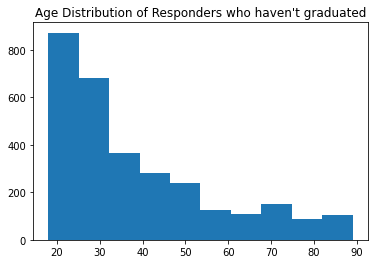

In [26]:
plt.hist(train.loc[train.Graduated == "No"].Age)
plt.title("Age Distribution of Responders who haven't graduated")

Text(0.5, 1.0, 'Age Distribution of All Responders')

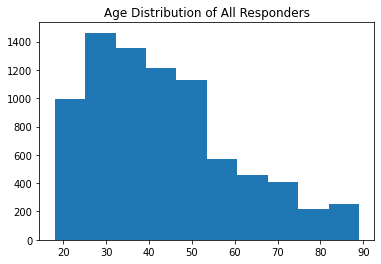

In [27]:
plt.hist(train.Age)
plt.title("Age Distribution of All Responders")

Clearly the people who haven't graduated are more likely to be young, probably because they're still in college. We can assume that the younger people haven't graduated.

In [28]:
train.loc[(train.Age <=21) & (train.Graduated.isna()), "Graduated"] = "No"

In [29]:
train.groupby(['Graduated']).count() #No's have changed from 3022

,ID,Gender,Ever_Married,Age,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Graduated,,,,,,,,,,
No,3030,3030,3030,3030,2966,2660,3030,2878,2994,3030
Yes,4968,4968,4968,4968,4915,4520,4968,4793,4928,4968


In [30]:
#changing all other values with the Mode of the column i.e. "Yes"
train.loc[train.Graduated.isna(), "Graduated"] = "Yes"

In [31]:
train.groupby(['Graduated']).count() #Yes's have changed from 4968

,ID,Gender,Ever_Married,Age,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Graduated,,,,,,,,,,
No,3030,3030,3030,3030,2966,2660,3030,2878,2994,3030
Yes,5038,5038,5038,5038,4978,4579,5038,4855,4998,5038


##### Profession

In [32]:
train.groupby(['Profession']).count()

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Profession,,,,,,,,,,
Artist,2516,2516,2516,2516,2516,2305,2516,2447,2491,2516
Doctor,688,688,688,688,688,630,688,662,683,688
Engineer,699,699,699,699,699,628,699,673,694,699
Entertainment,949,949,949,949,949,862,949,909,943,949
Executive,599,599,599,599,599,528,599,585,594,599
Healthcare,1332,1332,1332,1332,1332,1184,1332,1264,1317,1332
Homemaker,246,246,246,246,246,211,246,216,242,246
Lawyer,623,623,623,623,623,540,623,590,617,623
Marketing,292,292,292,292,292,253,292,275,290,292


(array([850., 293., 295., 230.,   0., 288., 106., 385., 174., 345.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

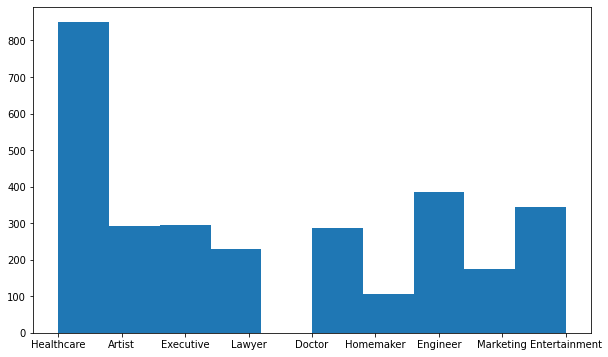

In [33]:
#most of the people who haven't graduated are in Healthcare
plt.figure(figsize=(10,6))
plt.hist(train.loc[(train.Graduated == "No") & (train.Profession.isna() == False)].Profession)

(array([ 314.,  393.,  604.,  482.,    0., 2223.,  140.,  400.,  304.,
         118.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

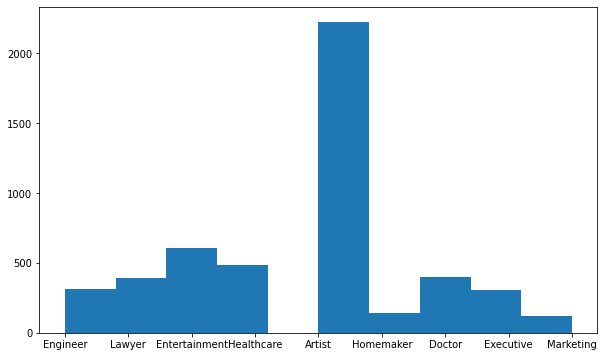

In [34]:
#Peoplewho have Graduated are most commonly Artists
plt.figure(figsize=(10,6))
plt.hist(train.loc[(train.Graduated == "Yes") & (train.Profession.isna() == False)].Profession)

In [35]:
#adding Healthcare as Profession for people who haven't graduated
train.loc[(train.Graduated == "No") & (train.Profession.isna()), 'Profession'] = 'Healthcare'

In [36]:
#adding Artist as Profession for people who have graduated
train.loc[(train.Graduated == "Yes") & (train.Profession.isna()), 'Profession'] = 'Artist'

In [37]:
train.groupby(['Profession']).count() #Artist (2516) and Healthcare (1332) entries have increased

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Profession,,,,,,,,,,
Artist,2576,2576,2576,2576,2576,2355,2576,2503,2549,2576
Doctor,688,688,688,688,688,630,688,662,683,688
Engineer,699,699,699,699,699,628,699,673,694,699
Entertainment,949,949,949,949,949,862,949,909,943,949
Executive,599,599,599,599,599,528,599,585,594,599
Healthcare,1396,1396,1396,1396,1396,1232,1396,1320,1380,1396
Homemaker,246,246,246,246,246,211,246,216,242,246
Lawyer,623,623,623,623,623,540,623,590,617,623
Marketing,292,292,292,292,292,253,292,275,290,292


##### Work Experience

(array([4672.,  286.,  508.,  194.,  204.,  659.,  474.,  103.,   48.,
          91.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

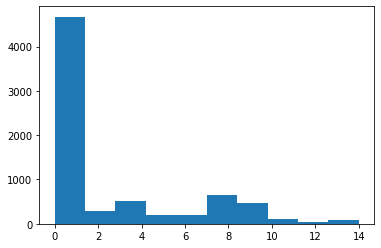

In [38]:
plt.hist(train.Work_Experience)

In [39]:
#replacing nan values with 1.0
train.loc[(train.Work_Experience.isna()), "Work_Experience"] = 1.0

##### Family Size

In [40]:
train.groupby(["Family_Size"]).count()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Var_1,Segmentation
Family_Size,,,,,,,,,,
1.0,1453,1453,1453,1453,1453,1453,1453,1453,1441,1453
2.0,2390,2390,2390,2390,2390,2390,2390,2390,2371,2390
3.0,1497,1497,1497,1497,1497,1497,1497,1497,1487,1497
4.0,1379,1379,1379,1379,1379,1379,1379,1379,1367,1379
5.0,612,612,612,612,612,612,612,612,603,612
6.0,212,212,212,212,212,212,212,212,212,212
7.0,96,96,96,96,96,96,96,96,96,96
8.0,50,50,50,50,50,50,50,50,50,50
9.0,44,44,44,44,44,44,44,44,44,44


In [41]:
train.Family_Size.mode()

0    2.0
dtype: float64

(array([1453., 2390., 1497., 1379.,    0.,  612.,  212.,   96.,   50.,
          44.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

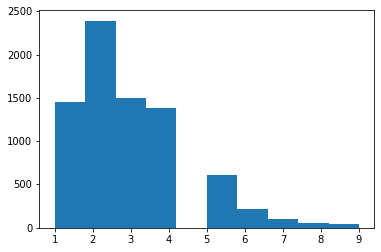

In [42]:
plt.hist(train.Family_Size)

In [43]:
#replacing nan values with the mode of the column, i.e. 2.0
train.loc[train.Family_Size.isna(), 'Family_Size'] = 2.0


In [44]:
train.groupby(['Family_Size']).count() #the 2's have in creased from 2390

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Var_1,Segmentation
Family_Size,,,,,,,,,,
1.0,1453,1453,1453,1453,1453,1453,1453,1453,1441,1453
2.0,2725,2725,2725,2725,2725,2725,2725,2725,2692,2725
3.0,1497,1497,1497,1497,1497,1497,1497,1497,1487,1497
4.0,1379,1379,1379,1379,1379,1379,1379,1379,1367,1379
5.0,612,612,612,612,612,612,612,612,603,612
6.0,212,212,212,212,212,212,212,212,212,212
7.0,96,96,96,96,96,96,96,96,96,96
8.0,50,50,50,50,50,50,50,50,50,50
9.0,44,44,44,44,44,44,44,44,44,44


##### Var_1

In [45]:
train.groupby(['Var_1']).count()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
Var_1,,,,,,,,,,
Cat_1,133,133,133,133,133,133,133,133,133,133
Cat_2,422,422,422,422,422,422,422,422,422,422
Cat_3,822,822,822,822,822,822,822,822,822,822
Cat_4,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
Cat_5,85,85,85,85,85,85,85,85,85,85
Cat_6,5238,5238,5238,5238,5238,5238,5238,5238,5238,5238
Cat_7,203,203,203,203,203,203,203,203,203,203


In [46]:
#replacing nan values with Cat_6
train.loc[train.Var_1.isna(), 'Var_1'] = 'Cat_6'

In [47]:
train.groupby(['Var_1']).count() #Cat_6 have increased from 5238

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
Var_1,,,,,,,,,,
Cat_1,133,133,133,133,133,133,133,133,133,133
Cat_2,422,422,422,422,422,422,422,422,422,422
Cat_3,822,822,822,822,822,822,822,822,822,822
Cat_4,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
Cat_5,85,85,85,85,85,85,85,85,85,85
Cat_6,5314,5314,5314,5314,5314,5314,5314,5314,5314,5314
Cat_7,203,203,203,203,203,203,203,203,203,203


###### No nan Values anymore

In [48]:
train.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

#### Predictor Variables

In [49]:
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,Healthcare,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


### Setting up Inputs to Neural Network

In [50]:
#use dummy variables to convert categorical variables into numerical variables
x_train = pd.get_dummies(train.iloc[:,1:-1]) #x_train are all independent variables

In [51]:
x_train.shape

(8068, 28)

In [52]:
y_train = pd.get_dummies(train.Segmentation) #y_train are dependent variables

In [53]:
y_train = y_train.astype(float)

In [54]:
y_train.shape

(8068, 4)

## Neural Network

In [55]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [57]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(18, kernel_initializer = 'random_normal', use_bias = True, bias_initializer="random_normal", activation='relu',input_dim = 28))

# Adding the second hidden layer
classifier.add(Dense(13, kernel_initializer = 'random_normal', use_bias = True, bias_initializer="random_normal", activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(9, kernel_initializer = 'random_normal', use_bias = True, bias_initializer="random_normal", activation='relu'))

#Adding the fourth hidden layer
classifier.add(Dense(6, kernel_initializer = "random_normal", use_bias= True, bias_initializer= "random_normal", activation='relu'))

# Adding the output layer
classifier.add(Dense(4, kernel_initializer = 'random_normal',use_bias = True, bias_initializer="random_normal", activation='relu'))

# Compiling the ANN
classifier.compile(loss=root_mean_squared_error, optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(x_train.values, y_train.values,validation_split=0.20, batch_size = 32, epochs = 1000)

Epoch 1/1000
202/202 [==============================] - 1s 2ms/step - loss: 0.4860 - val_loss: 0.4695
Epoch 2/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4667 - val_loss: 0.4673
Epoch 3/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4656 - val_loss: 0.4657
Epoch 4/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4629 - val_loss: 0.4604
Epoch 5/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4562 - val_loss: 0.4533
Epoch 6/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4496 - val_loss: 0.4484
Epoch 7/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.4441 - val_loss: 0.4465
Epoch 8/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4433 - val_loss: 0.4448
Epoch 9/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.4430 - val_loss: 0.4440
Epoch 10/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.443

Prediction

In [81]:
x_test = pd.read_csv(io.BytesIO(uploaded['x_test.csv']))

In [82]:
x_test = x_test.iloc[:,1:]

In [90]:
predictions = pd.DataFrame(classifier.predict(x_test))

In [91]:
predictions.head()

,0,1,2,3
0,0.437051,0.350882,0.082679,0.122625
1,0.431146,0.174896,0.193584,0.216529
2,0.158453,0.043081,0.030802,0.698894
3,0.402218,0.154786,0.322090,0.142152
4,0.177844,0.112567,0.105131,0.576608


In [92]:
predictions.columns = ['A', 'B', 'C', 'D']

In [93]:
predictions = pd.DataFrame(predictions.idxmax(axis = 1))


In [94]:
predictions['ID'] = test.iloc[:,0]

In [95]:
predictions.head()

,0,ID
0,A,458989
1,A,458994
2,D,458996
3,A,459000
4,D,459001


In [97]:
# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')


Mounted at /gdrive


In [109]:
predictions.to_csv('Predictions.csv', index = False)
!cp Predictions.csv "/gdrive/My Drive/"